<a href="https://colab.research.google.com/github/sul01/MSDS-CODE/blob/master/hw3/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preprocessing

In [1]:
import numpy as np
import pandas as pd

#loading
BITSTREAMVERA = pd.read_csv("https://raw.githubusercontent.com/CharlesColgan/MSDS-6350-6373-CODE/master/hw2/BITSTREAMVERA.csv")
CENTURY = pd.read_csv('https://raw.githubusercontent.com/sul01/MSDS-CODE/master/hw3/CENTURY.csv')
CONSOLAS = pd.read_csv("https://raw.githubusercontent.com/CharlesColgan/MSDS-6350-6373-CODE/master/hw2/CONSOLAS.csv")
EBRIMA = pd.read_csv("https://raw.githubusercontent.com/CharlesColgan/MSDS-6350-6373-CODE/master/hw2/EBRIMA.csv")
GILL = pd.read_csv('https://raw.githubusercontent.com/sul01/MSDS-CODE/master/hw3/GILL.csv')

#cleaning
drop_names = ["fontVariant","m_label","orientation","m_top","m_left","originalH","originalW","h","w"]
FONT = [BITSTREAMVERA, CENTURY, CONSOLAS, EBRIMA, GILL]; CL = []
for i in range(5):
  CL.append(FONT[i][(FONT[i]['strength']==0.4) & (FONT[i]['italic']==0)].drop(drop_names,axis=1))

#transforming
def fontToMatrix(font, df):
  for case in range(df.shape[0]):
    font[case] =  np.array(df[df.columns[3:]].iloc[case]).reshape(20,20)

FONT_mat = [] #font as 20x20 matrix
for i in range(5):
  FONT_mat.append(np.empty((CL[i].shape[0],20,20), int))
  fontToMatrix(FONT_mat[i], CL[i])

Examples

Bitstream



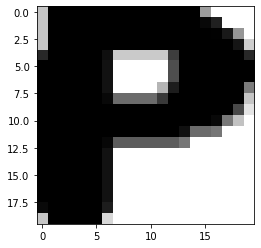

Century



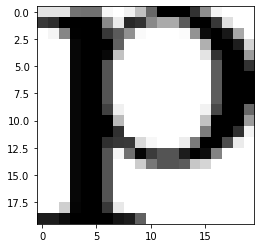

Consolas



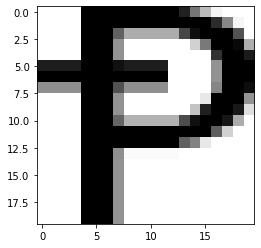

Ebrima



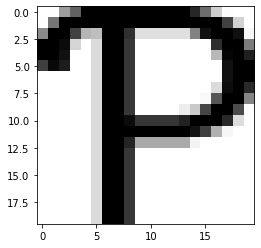

Gill



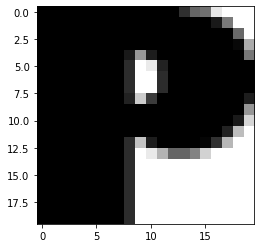

In [5]:
import matplotlib.pyplot as plt

print('Bitstream\n'); plt.imshow(FONT_mat[0][8], cmap=plt.cm.binary); plt.show() 
print('Century\n'); plt.imshow(FONT_mat[1][199], cmap=plt.cm.binary); plt.show() 
print('Consolas\n'); plt.imshow(FONT_mat[2][26], cmap=plt.cm.binary); plt.show() 
print('Ebrima\n'); plt.imshow(FONT_mat[3][1387], cmap=plt.cm.binary); plt.show() 
print('Gill\n'); plt.imshow(FONT_mat[4][243], cmap=plt.cm.binary); plt.show() 

train/test split

In [2]:
from sklearn.model_selection import train_test_split

def ypred(x, model):
  return list(map({0:'BITSTREAMVERA', 1:'CENTURY', 2:'CONSOLAS', 3:'EBRIMA', 4:'GILL'}.get, model.predict(x).argmax(axis = -1)))

dataX = np.concatenate(([FONT_mat[i] for i in range(5)])).reshape(-1,20,20,1)
dataY = np.concatenate(([CL[i]['font'] for i in range(5)]))
train, test = train_test_split(range(dataX.shape[0]), test_size = 0.2, random_state = 0)
x_train = dataX[train]; x_test = dataX[test]
y_train = dataY[train]; y_test = dataY[test]

#CNN

(https://www.tensorflow.org/tutorials/images/cnn)

In [3]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

#build (step 3)
model = models.Sequential()
model.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=(20, 20, 1)))
model.add(layers.MaxPooling2D((2, 2), strides= 2))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides= 2))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu')) #100 chosen at random
model.add(layers.Dense(5))
#model.summary()

model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
monitor = model.fit(x_train, tf.one_hot(pd.Series(y_train,dtype='category').astype('category').cat.codes,5), epochs=20,
                    validation_data=(x_test, tf.one_hot(pd.Series(y_test, dtype='category').astype('category').cat.codes,5)))

Epoch 1/20
245/245 [==============================] - 3s 11ms/step - loss: 5.5072 - accuracy: 0.3029 - val_loss: 1.4000 - val_accuracy: 0.4403
Epoch 2/20
245/245 [==============================] - 2s 9ms/step - loss: 1.3161 - accuracy: 0.4816 - val_loss: 1.1799 - val_accuracy: 0.5448
Epoch 3/20
245/245 [==============================] - 2s 9ms/step - loss: 1.0975 - accuracy: 0.5865 - val_loss: 1.0755 - val_accuracy: 0.5893
Epoch 4/20
245/245 [==============================] - 2s 9ms/step - loss: 1.0146 - accuracy: 0.6134 - val_loss: 0.9837 - val_accuracy: 0.6257
Epoch 5/20
245/245 [==============================] - 2s 9ms/step - loss: 0.9074 - accuracy: 0.6514 - val_loss: 0.9419 - val_accuracy: 0.6487
Epoch 6/20
245/245 [==============================] - 2s 9ms/step - loss: 0.8115 - accuracy: 0.7039 - val_loss: 0.9406 - val_accuracy: 0.6523
Epoch 7/20
245/245 [==============================] - 2s 9ms/step - loss: 0.7796 - accuracy: 0.7145 - val_loss: 0.9096 - val_accuracy: 0.6523
Epoch

Performance during learning (currently incorrect for training sets)

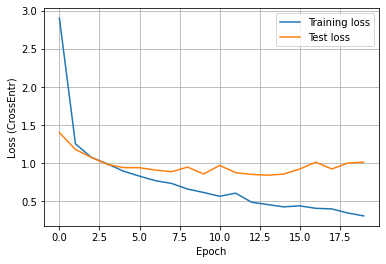

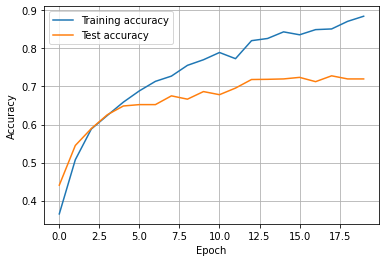

In [6]:
def plotCrssEntr(monitor):
  plt.plot(monitor.model.history.history['loss'], label = 'Training loss')
  plt.plot(monitor.model.history.history['val_loss'], label = 'Test loss')
  plt.xlabel('Epoch'); plt.ylabel('Loss (CrossEntr)')
  plt.legend(); plt.grid(True); plt.show()

def plotAcc(monitor):
  plt.plot(monitor.model.history.history['accuracy'], label = 'Training accuracy')
  plt.plot(monitor.model.history.history['val_accuracy'], label = 'Test accuracy')
  plt.xlabel('Epoch'); plt.ylabel('Accuracy')
  plt.legend(); plt.grid(True); plt.show()

plotCrssEntr(monitor); plotAcc(monitor)

Conf Matirx

In [7]:
def conf(actu, pred):
  y_actu = pd.Series(np.array(actu), name = 'Actual')
  y_pred = pd.Series(pred, name = 'Predicted')
  df_confusion = pd.crosstab(y_actu, y_pred)
  return df_confusion/ df_confusion.sum()

trainConf = conf(y_train, ypred(x_train, monitor.model))
print('Train:\n', trainConf)

testConf = conf(y_test, ypred(x_test, monitor.model))
print('\nTest:\n', testConf)

Train:
 Predicted      BITSTREAMVERA   CENTURY  CONSOLAS    EBRIMA      GILL
Actual                                                              
BITSTREAMVERA       0.960795  0.005580  0.015969  0.004125  0.019521
CENTURY             0.004296  0.852679  0.019273  0.016502  0.027507
CONSOLAS            0.016649  0.045759  0.886564  0.019802  0.044366
EBRIMA              0.006445  0.041853  0.047907  0.950495  0.042591
GILL                0.011815  0.054129  0.030286  0.009076  0.866016

Test:
 Predicted      BITSTREAMVERA   CENTURY  CONSOLAS    EBRIMA      GILL
Actual                                                              
BITSTREAMVERA       0.857143  0.012632  0.035197  0.012397  0.045775
CENTURY             0.008529  0.677895  0.037267  0.070248  0.056338
CONSOLAS            0.055437  0.109474  0.683230  0.181818  0.126761
EBRIMA              0.017058  0.141053  0.171843  0.669421  0.102113
GILL                0.061834  0.058947  0.072464  0.066116  0.669014


array([0, 1, 3, ..., 2, 2, 0])